In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print
# tf.compat.v1.disable_eager_execution()

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [3]:
## these can also be globally set.
trial_seed = 1
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)

In [42]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

In [43]:
# Replaced all list identifies (i.e. cam_list) with variables indicating single image usage.
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear ## What does this do? put a note
        return model
    
    gradcam_image = validation_images[cam_img]
    gradcam = Gradcam(m, model_modifier = model_modifier) # line throws 'ValueError: Unknown activation function: guidedRelu' when called repeatedly within guided gradcam
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) ## What does `penultimate_layer` do? Check github to see if option is still active
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, index

In [44]:
gcam101 = grad_cam([101])

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 3.7088735 -3.9274487]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.7088735>]
[array([9.9951756e-01, 4.8236738e-04], dtype=float32)]
Shape of heatmap matrix: (128, 128)


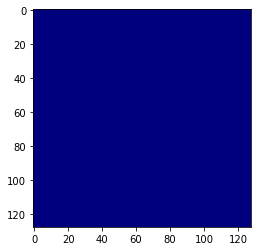

In [54]:
plt.imshow(np.squeeze(gcam101[0]), cmap="jet")

In [46]:
def guided_backprop(index, activation_layer):#101
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
    backprop_image = validation_images[index]    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads  

In [47]:
gbp101 = guided_backprop([101], 'conv2d_4' )

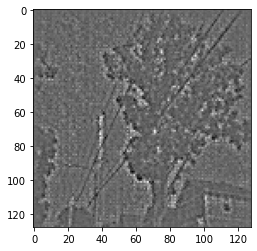

In [62]:
plt.imshow(np.squeeze(gbp101), cmap="gist_gray")

The deprocessing function standardizes (subtract mean, divide by standard dev) the image. This makes for a higher contrast image, but not too informative in our case, given the low resolution.

In [59]:
# @Nasko: put this in the helper script
# Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=4-OduFD-wH14&line=15&uniqifier=1
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     if K.image_data_format() == 'channels_first':
#         x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

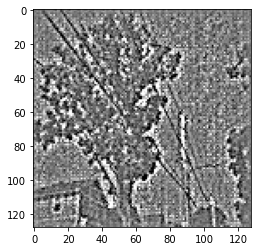

In [60]:
plt.imshow(np.flip(deprocess_image(np.array(np.squeeze(gbp101))),-1), cmap = "gist_gray")

In [63]:
def guided_gradcam(gcam, gbp, c_map='gist_gray'):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    ggcam = gcam[0] * gbp
#     ggcam = np.squeeze(ggcam[0])
    print('Shape of GGCAM: ', ggcam.shape)
    
    guided_gradcam = '../../figures/plottingGuided-GradCam/'
    if not os.path.exists(guided_gradcam):
        os.makedirs(guided_gradcam)
    
    plt.figure(figsize=(5, 5))
    plt.suptitle('Guided Grad-CAM')
    plt.title('Index ' + str(gcam[2]), y=-0.06)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(ggcam, cmap=c_map)
    plt.subplots_adjust(top=0.92)
#     plt.savefig(guided_gradcam+"guided-gradcam-index-"+str(gcam[2])+'-'+c_map+".png")
    plt.show()

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 3.6232486 -3.622695 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.6232486>]
[array([9.9928737e-01, 7.1255281e-04], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


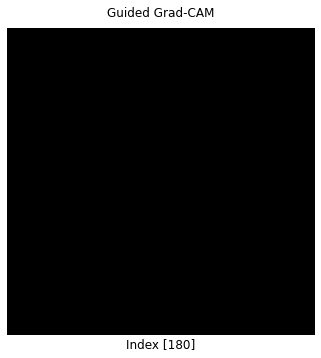

In [67]:
guided_gradcam(grad_cam([180]), deprocess_image(np.array(np.squeeze(guided_backprop([180], 'conv2d_4')))))